# RNA-based Segmentation

This notebook showcases end-to-end RNA-based cell segmentation. This is done in two broad steps.

1. Identify individual nuclei from nuclearly localized genes (`Malat1`) and unspliced RNA signal.
2. From these nuclei, identify cells.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/mnt/c/Users/phoen/Documents/GitHub/spateo-release')

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/home/lioscro/miniconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/lioscro/miniconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/lioscro/miniconda3/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and opera

## Load the data
`st.io.read_bgi_agg` reads in aggregated UMI counts per pixel. The `gene_agg` argument specifies additional layers to create based on the combined counts of the provided genes.

In [2]:
adata = st.io.read_bgi_agg(
    'data/SS200000135TL_D1_all_bin1.txt.gz',
    scale=0.5,
    scale_unit='um',
    gene_agg={'nuclear': ['Malat1']}
)
adata

AnnData object with n_obs × n_vars = 2000 × 2000
    uns: '__type', 'pp', 'spatial'
    layers: 'spliced', 'unspliced', 'nuclear'

## 1. Nuclei segmentation

In this step, we segment and label individual nuclei. This is in the following steps.

1. Identify nuclei using nuclearly localized `Malat1` gene signal.
2. Using these nuclei as "seeds", identify additional nuclei based on unspliced RNA signal. This steps involves segmenting the slice into RNA density bins, and then computing the marginal probability at each pixel that the pixel is occupied by a nucleus (the technical details of which we will ignore).

Running EM: 100%|##########| 1/1 [00:26<00:00, 26.23s/it]


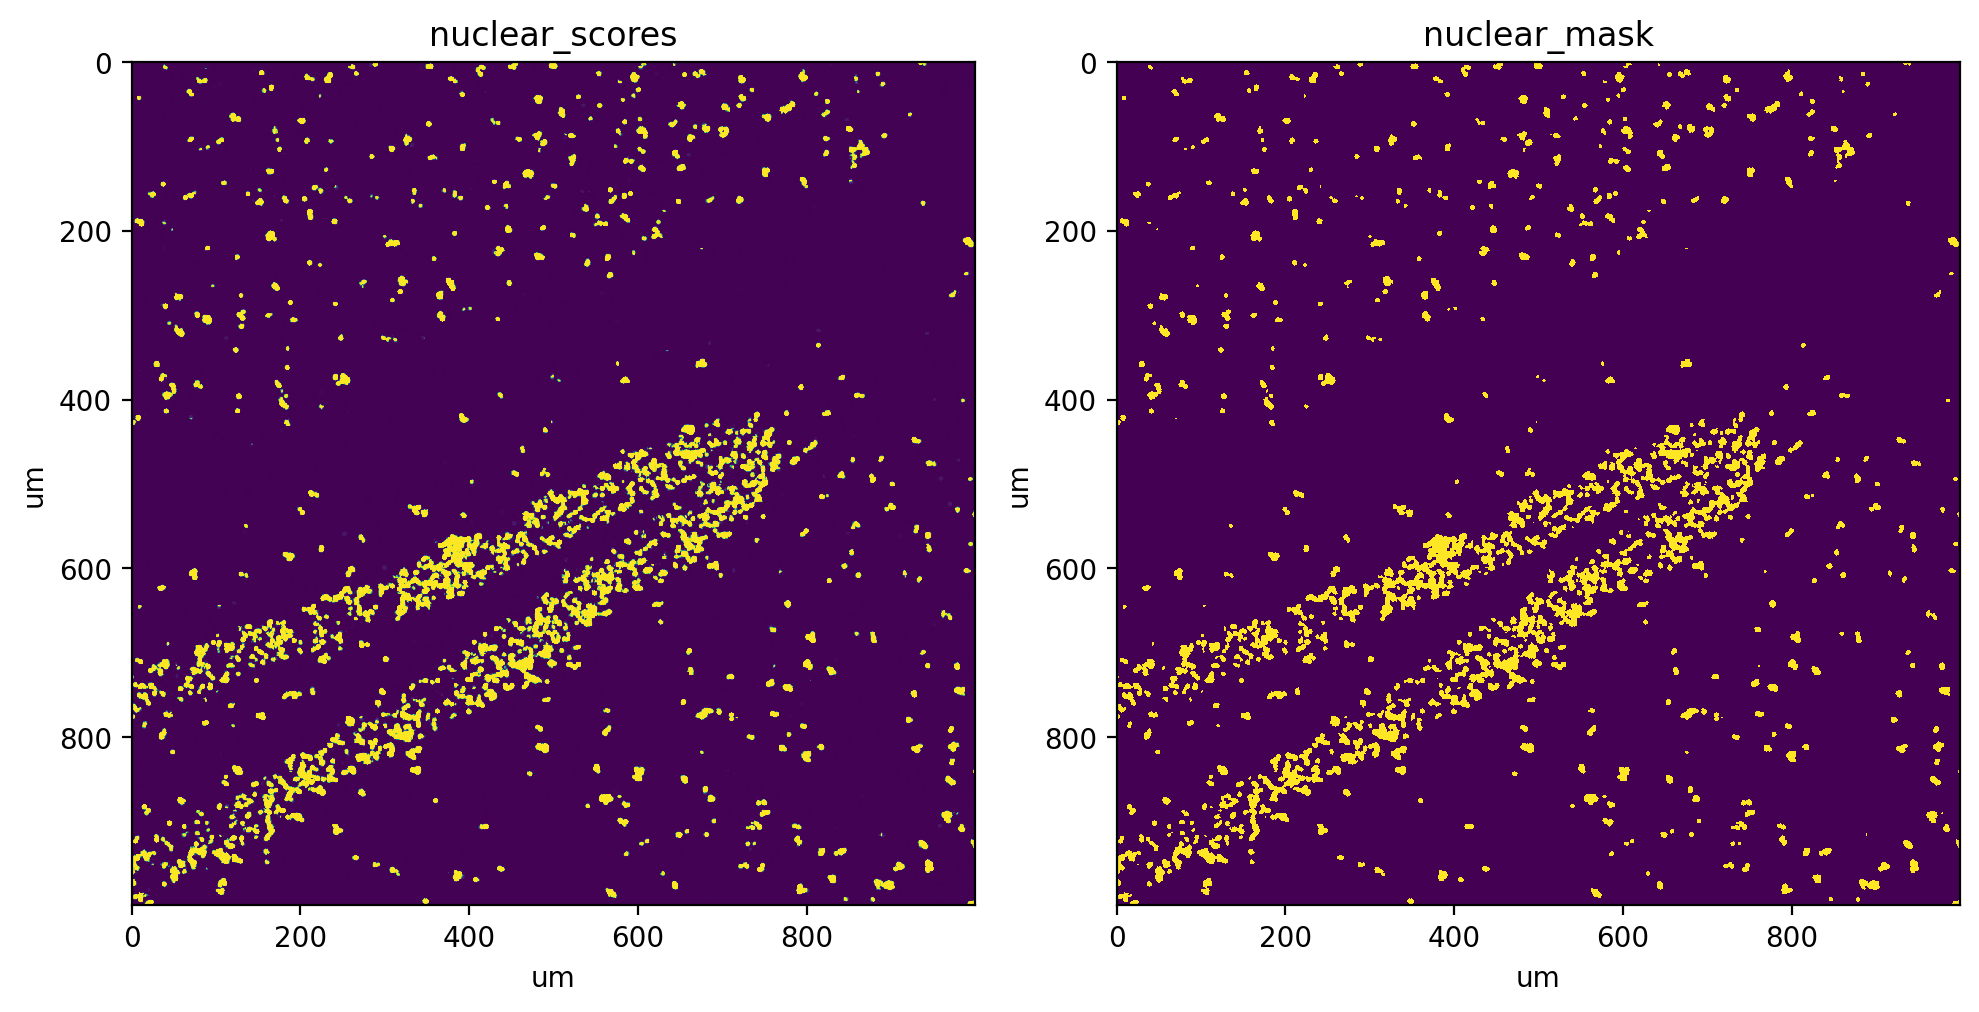

In [3]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'nuclear', k=13, method='EM+BP',
    em_kwargs=dict(downsample=0.01, seed=2022, n_threads=8),
    bp_kwargs=dict(n_threads=8, p=0.7, q=0.3), mk=3
)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'nuclear_scores', ax=axes[0])
st.pl.imshow(adata, 'nuclear_mask', ax=axes[1])

Then, we label each connected component a unique integer label.

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'nuclear_labels'}, xlabel='um', ylabel='um'>)

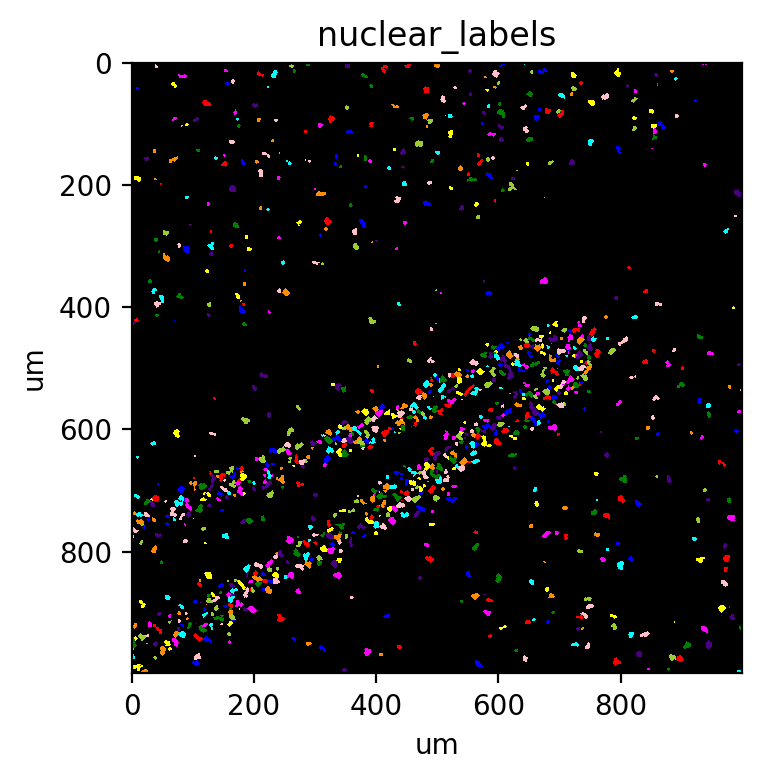

In [4]:
st.pp.segmentation.label_connected_components(adata, 'nuclear')
st.pl.imshow(adata, 'nuclear_labels', labels=True)

Now, segment the tissue into RNA density bins.

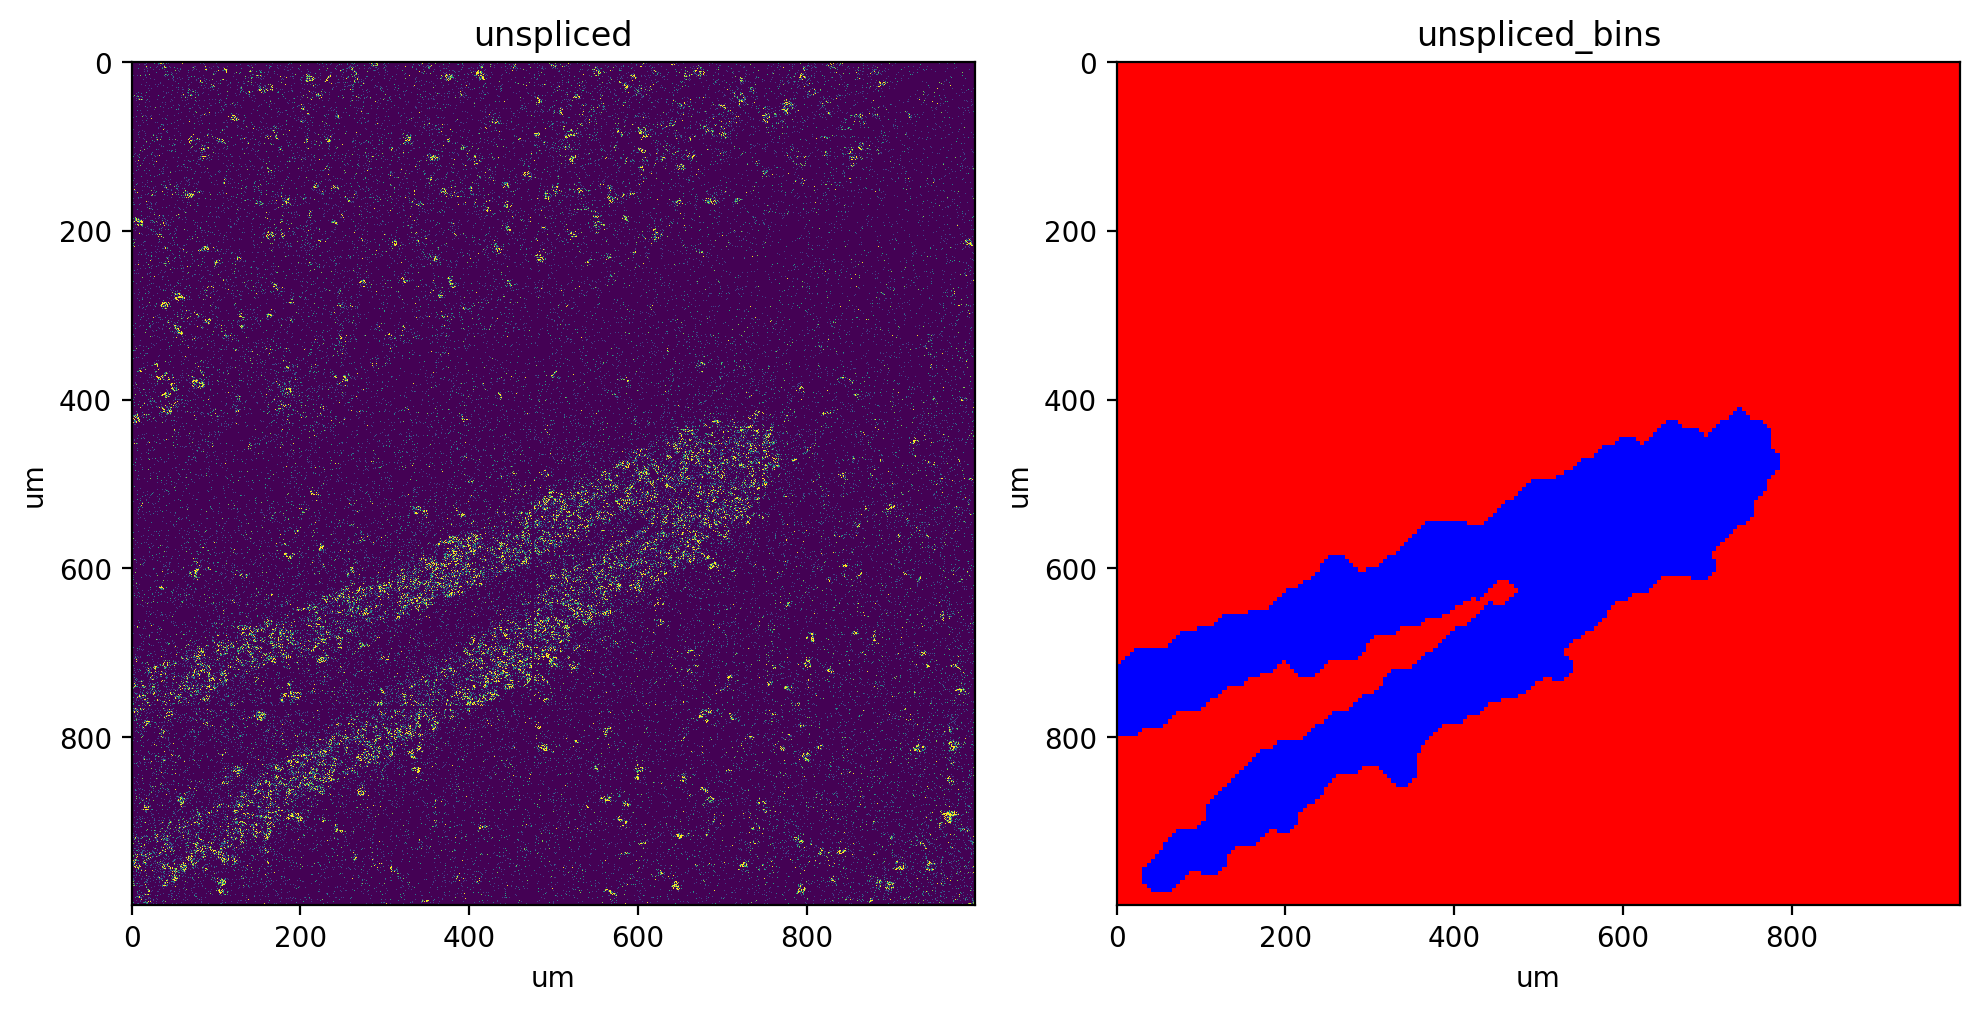

In [5]:
st.pp.segmentation.segment_densities(adata, 'unspliced', 10, k=7, dk=5, distance_threshold=5, background=False)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'unspliced', vmax=5, ax=axes[0])
st.pl.imshow(adata, 'unspliced_bins', ax=axes[1], labels=True)

Running EM: 100%|##########| 2/2 [00:10<00:00,  5.11s/it]


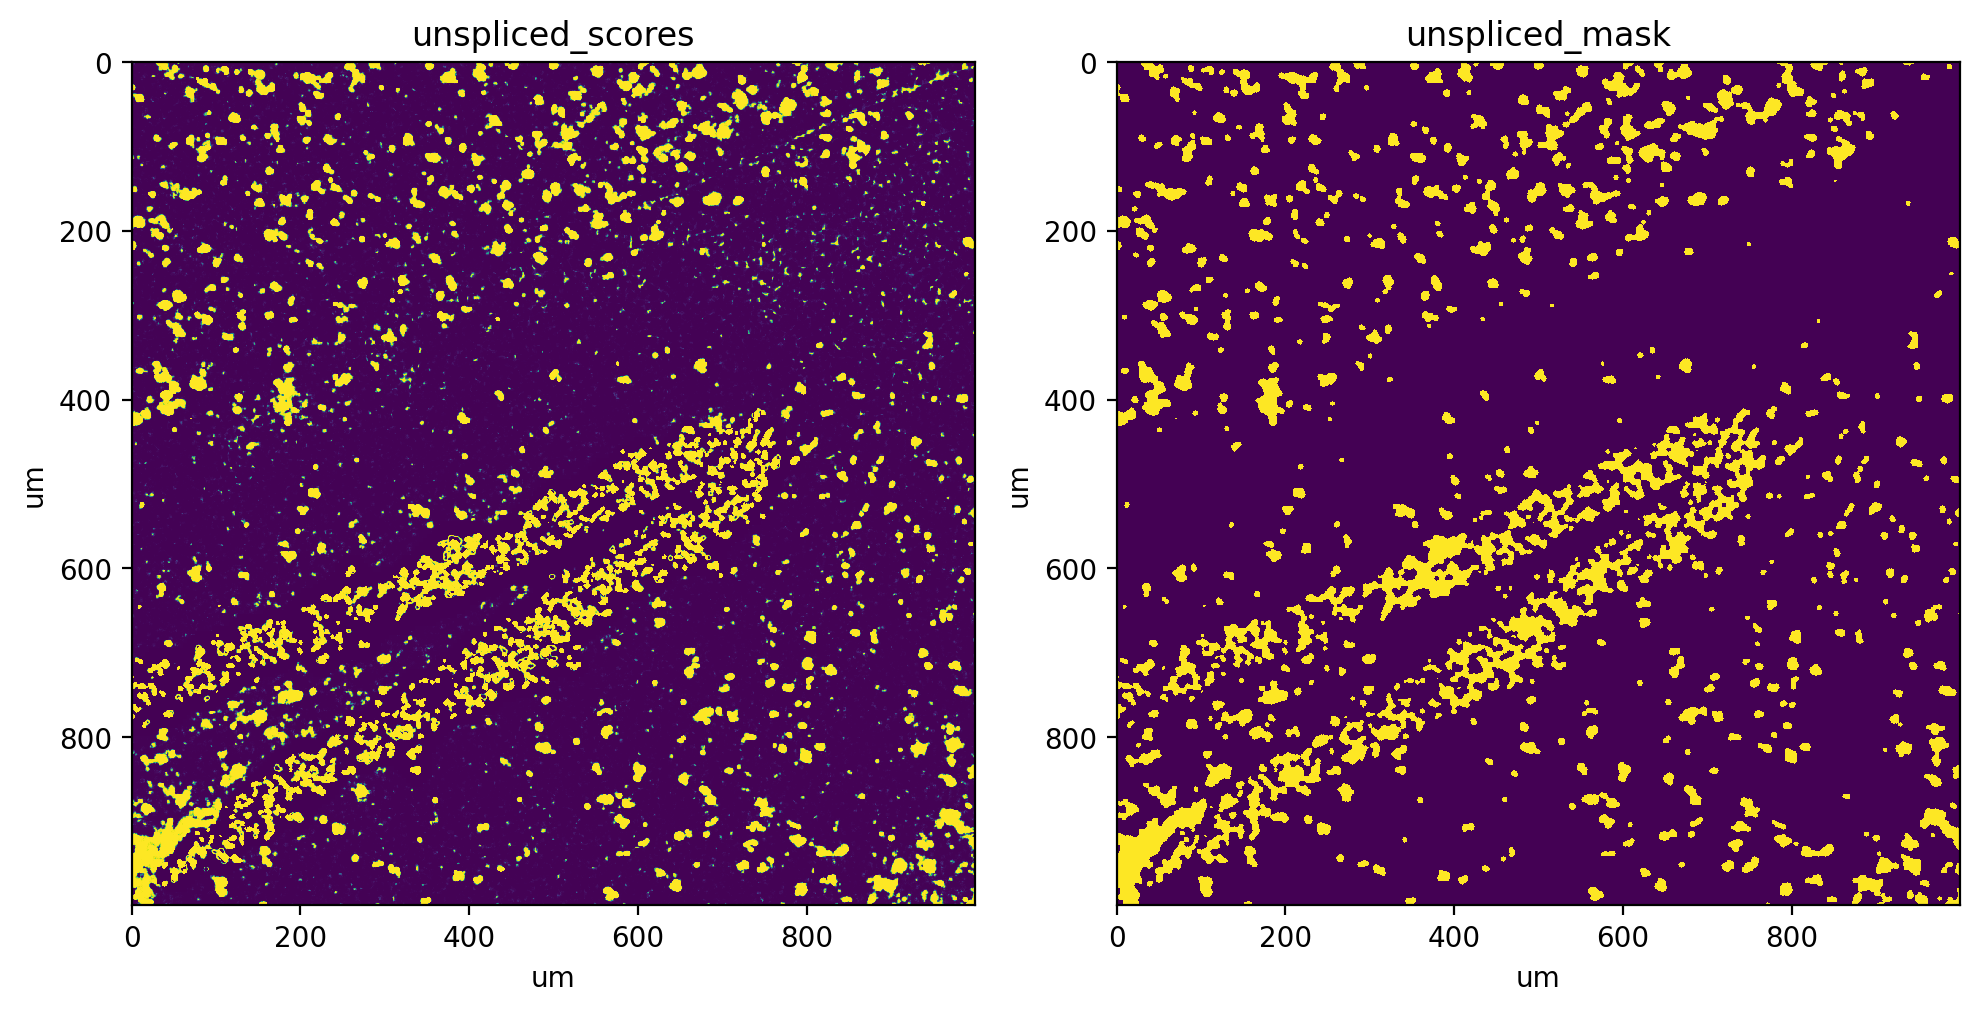

In [6]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'unspliced', k=13, method='EM+BP',
    em_kwargs=dict(downsample=0.01, seed=2022, n_threads=8),
    bp_kwargs=dict(n_threads=8, p=0.7, q=0.3),
    certain_layer='nuclear_labels'
)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'unspliced_scores', ax=axes[0])
st.pl.imshow(adata, 'unspliced_mask', ax=axes[1])

With the above nucleus mask, we try and identify individual nuclei. Note that we provide the `seed_layer` argument, which specifies the layer in the AnnData that contains "seed" labels. These labels will be used whenever possible in labeling the mask obtained from unspliced RNA signal.

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'unspliced_labels'}, xlabel='um', ylabel='um'>)

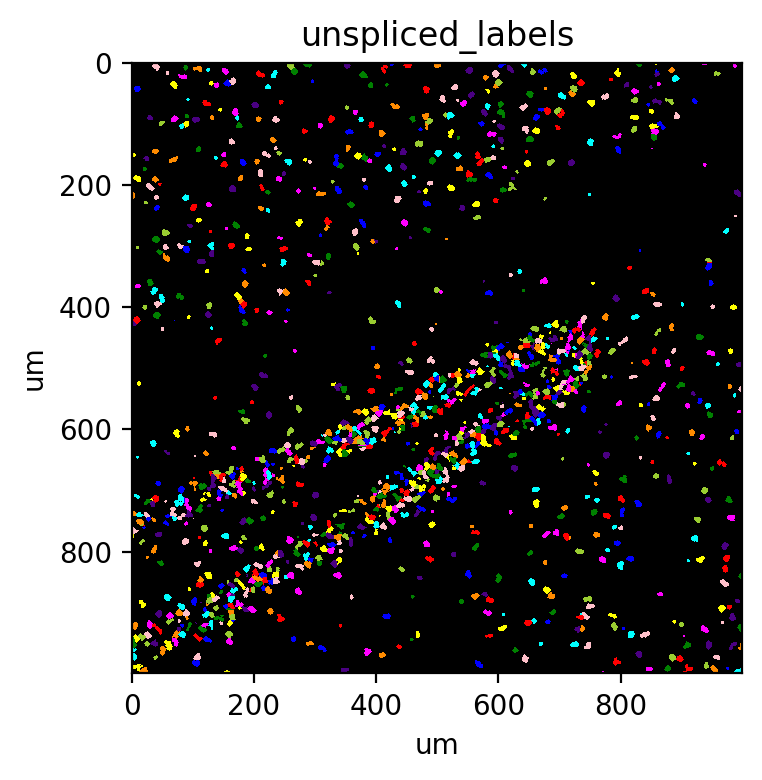

In [7]:
st.pp.segmentation.label_connected_components(adata, 'unspliced', seed_layer='nuclear_labels')
st.pl.imshow(adata, 'unspliced_labels', labels=True)

## 2. Cell segmentation

In this section, we use the labeled nuclei obtained above to guide our quest to identify individual cells.

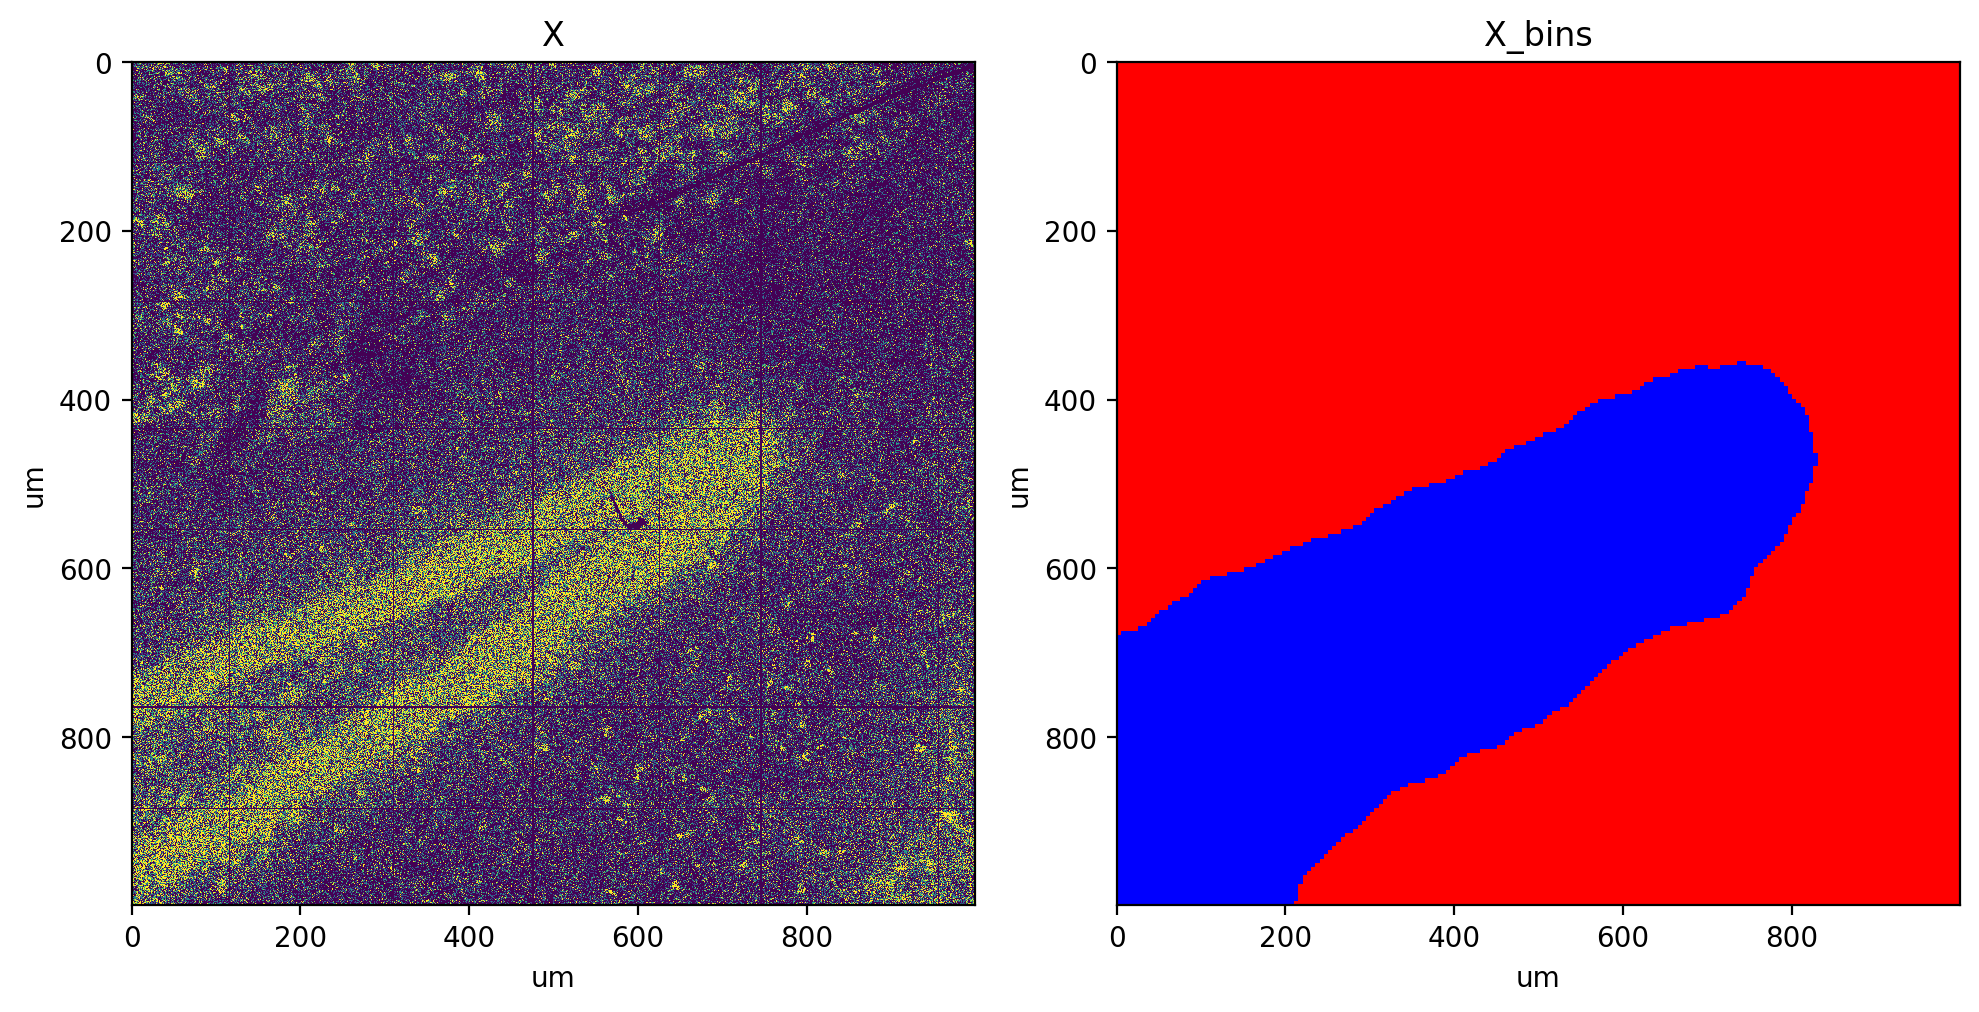

In [8]:
st.pp.segmentation.segment_densities(adata, 'X', 10, k=5, distance_threshold=10, dk=25, background=False)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'X', vmax=5, ax=axes[0])
st.pl.imshow(adata, 'X_bins', ax=axes[1], labels=True)

In the proceeding cell, notice the `certain_layer='unspliced_labels'` argument, which indicates the layer in the AnnData that contains the nuclei labels obtained from unspliced RNA signal.

Running EM: 100%|##########| 2/2 [00:21<00:00, 10.83s/it]


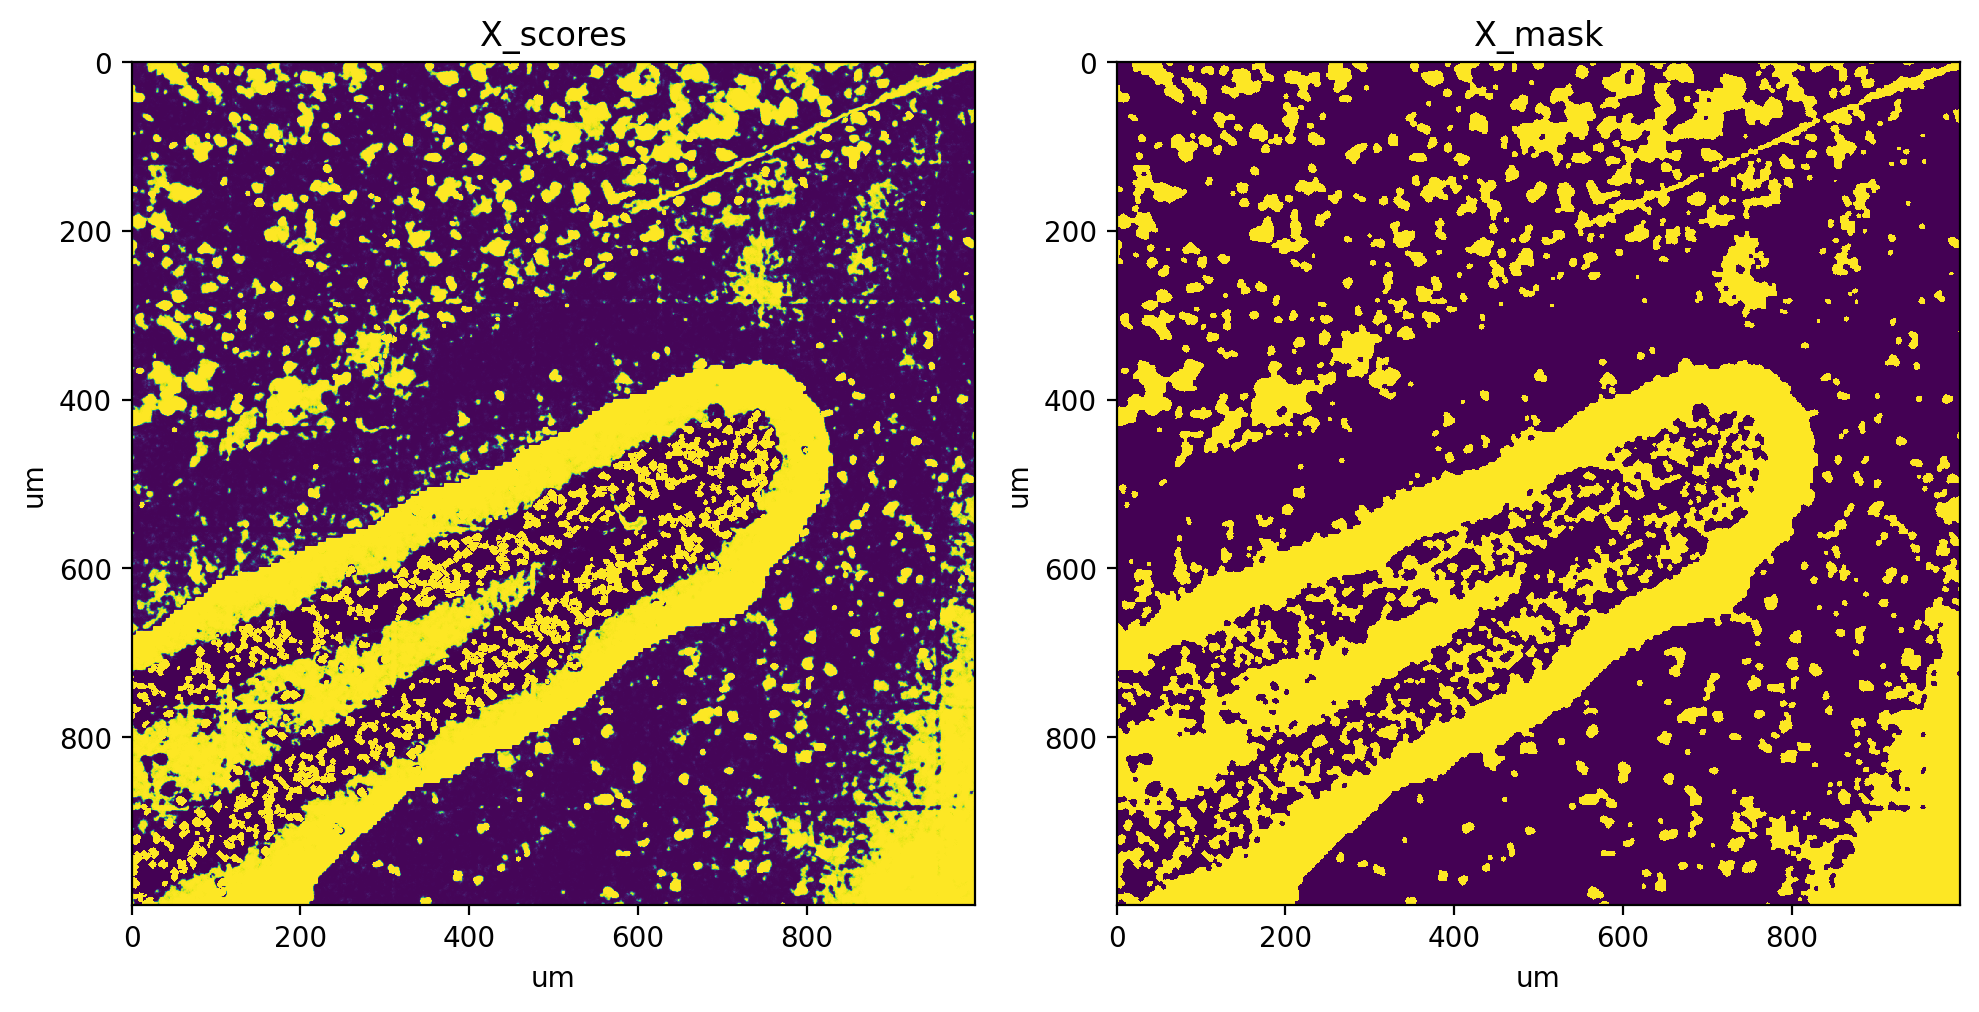

In [9]:
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=15, method='EM+BP',
    em_kwargs=dict(downsample=0.01, seed=2022),
    bp_kwargs=dict(n_threads=8, p=0.7, q=0.3),
    certain_layer='unspliced_labels'
)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'X_scores', ax=axes[0])
st.pl.imshow(adata, 'X_mask', ax=axes[1])

Finally, expand the nuclei labels so that each cell occupies up to a certain distance from the nucleus, while constraining the problem within the mask obtained in the previous cell.

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'X_labels'}, xlabel='um', ylabel='um'>)

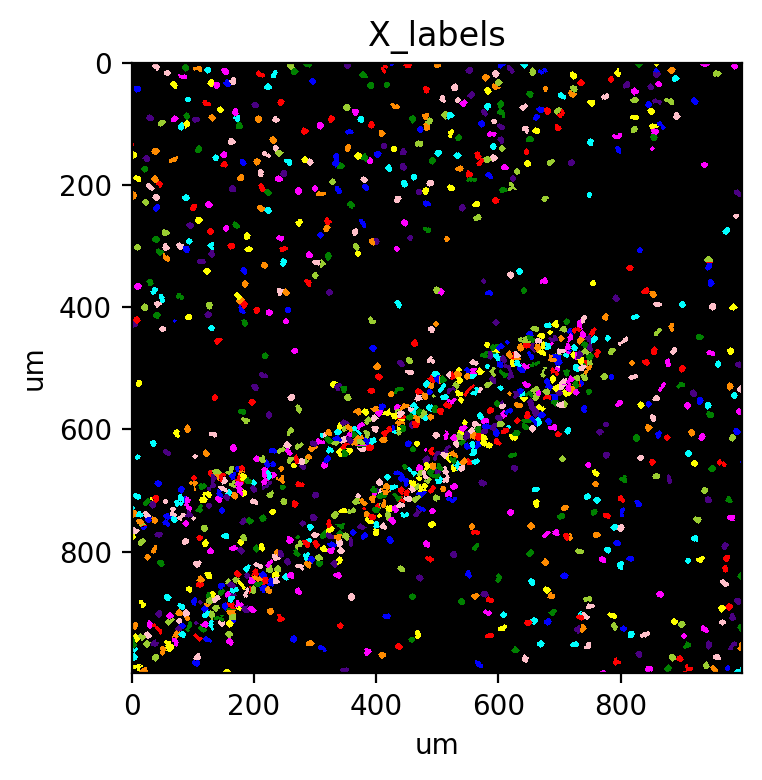

In [10]:
st.pp.segmentation.expand_labels(
    adata, 'unspliced', distance=5, max_area=400, mask_layer='X_mask', out_layer='X_labels'
)
st.pl.imshow(adata, 'X_labels', labels=True)

Expand these labels a couple pixels to take into account any diffusion.

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'X_labels_expanded'}, xlabel='um', ylabel='um'>)

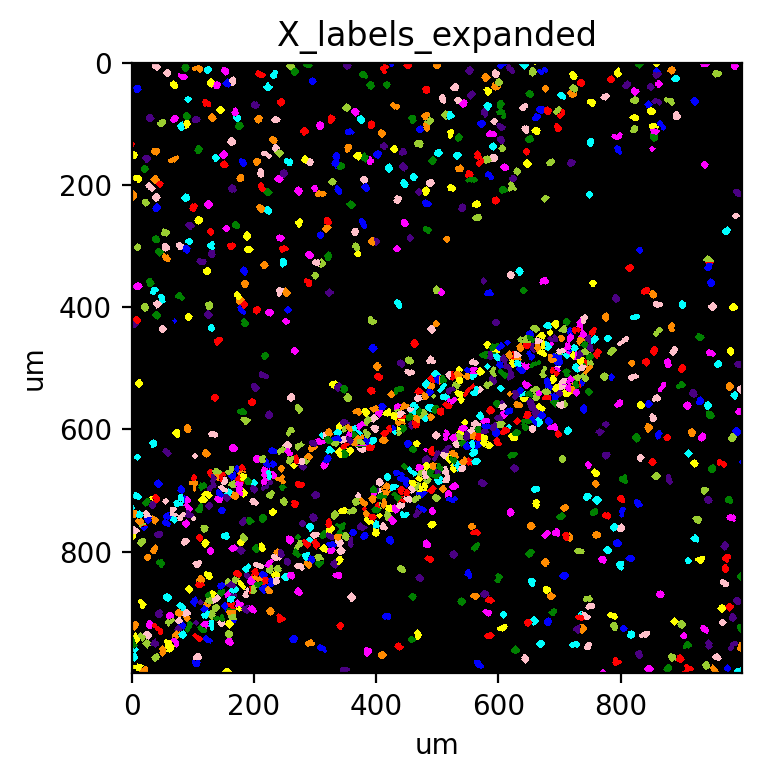

In [13]:
st.pp.segmentation.expand_labels(adata, 'X', distance=2, max_area=np.inf)
st.pl.imshow(adata, 'X_labels_expanded', labels=True)

In [14]:
adata.write('data/rna_segmentation.h5ad', compression='gzip')